# Testing Optimizer with graph models in KGCNN

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
dataset = ESOLDataset()
dataset.set_attributes()
dataset.map_list(method="set_edge_indices_reverse")

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name ESOL
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.ESOL:Found SDF C:\Users\patri\.kgcnn\datasets\ESOL\delaney-processed.sdf of pre-computed structures.
INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.data.ESOL: ... process molecules 1000 from 1128
INFO:kgcnn.mol.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br']
INFO:kgcnn.mol.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.mol.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.mol.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.mol.encoder:OneHotEnc

In [3]:
from kgcnn.literature.DMPNN import make_model

In [4]:
model_config = {
    "name": "DMPNN",
    "inputs": [
        {"shape": [None, 41], "name": "node_attributes", "dtype": "float32", "ragged": True},
        {"shape": [None, 11], "name": "edge_attributes", "dtype": "float32", "ragged": True},
        {"shape": [None, 2], "name": "edge_indices", "dtype": "int64", "ragged": True},
        {"shape": [None, 1], "name": "edge_indices_reverse", "dtype": "int64", "ragged": True}
    ],
    "input_embedding": {"node": {"input_dim": 95, "output_dim": 64},
                        "edge": {"input_dim": 5, "output_dim": 64}},
    "pooling_args": {"pooling_method": "sum"},
    "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
    "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
    "edge_activation": {"activation": "relu"},
    "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
    "verbose": 10, "depth": 5,
    "dropout": {"rate": 0.1},
    "output_embedding": "graph",
    "output_mlp": {
        "use_bias": [True, True, False], "units": [64, 32, 1],
        "activation": ["relu", "relu", "linear"]
    }
}
# Test making model
model = make_model(**model_config)

INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

In [5]:
dataset.clean(model_config["inputs"])

INFO:kgcnn.data.ESOL:Property edge_attributes is an empty list for graph 934.
INFO:kgcnn.data.ESOL:Property edge_indices is an empty list for graph 934.
INFO:kgcnn.data.ESOL:Property edge_indices_reverse is an empty list for graph 934.


array([934])

In [6]:
labels = np.expand_dims(dataset.get("graph_labels"), axis=-1)
labels.shape

(1127, 1)

In [7]:
from copy import deepcopy
from sklearn.model_selection import train_test_split
from keras.backend import clear_session

In [8]:
from kgcnn.training.optimizer import Adan
from tensorflow.keras.optimizers import Adam, SGD, Adamax, Adadelta

In [9]:
train_index, test_index = train_test_split(np.arange(len(dataset)), test_size=0.25, random_state=42)
x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
x_valid, y_valid = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]

In [10]:
hist_opt = []
# Adan
opt_selection = [
    Adan(), Adam(), 
    SGD(), Adamax(), Adadelta()]

for opt in opt_selection:
    model = make_model(**model_config)
    print(opt)
    model.compile(
        loss="mean_absolute_error",
        optimizer=opt,
        metrics=["mean_absolute_error"],
    )
    hist_run = model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        shuffle=True,
        batch_size=32,
        epochs=300,
    )
    hist_opt.append(hist_run)

INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_11/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_9/gather_nodes_outgoing_11/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_9/gather_nodes_outgoing_11/Reshape:0", shape=(Non

27/27 [==============================] - 7s 76ms/step - loss: 2.0856 - mean_absolute_error: 2.0856 - val_loss: 1.1591 - val_mean_absolute_error: 1.1591
Epoch 2/300
27/27 [==============================] - 1s 43ms/step - loss: 1.0265 - mean_absolute_error: 1.0265 - val_loss: 0.8844 - val_mean_absolute_error: 0.8844
Epoch 3/300
27/27 [==============================] - 1s 41ms/step - loss: 0.8624 - mean_absolute_error: 0.8624 - val_loss: 0.7943 - val_mean_absolute_error: 0.7943
Epoch 4/300
27/27 [==============================] - 1s 42ms/step - loss: 0.8211 - mean_absolute_error: 0.8211 - val_loss: 0.7779 - val_mean_absolute_error: 0.7779
Epoch 5/300
27/27 [==============================] - 1s 40ms/step - loss: 0.7631 - mean_absolute_error: 0.7631 - val_loss: 0.7466 - val_mean_absolute_error: 0.7466
Epoch 6/300
27/27 [==============================] - 1s 43ms/step - loss: 0.7411 - mean_absolute_error: 0.7411 - val_loss: 0.7292 - val_mean_absolute_error: 0.7292
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3324 - mean_absolute_error: 0.3324 - val_loss: 0.5011 - val_mean_absolute_error: 0.5011
Epoch 52/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3217 - mean_absolute_error: 0.3217 - val_loss: 0.4789 - val_mean_absolute_error: 0.4789
Epoch 53/300
27/27 [==============================] - 1s 32ms/step - loss: 0.3260 - mean_absolute_error: 0.3260 - val_loss: 0.5071 - val_mean_absolute_error: 0.5071
Epoch 54/300
27/27 [==============================] - 1s 33ms/step - loss: 0.3295 - mean_absolute_error: 0.3295 - val_loss: 0.4758 - val_mean_absolute_error: 0.4758
Epoch 55/300
27/27 [==============================] - 1s 34ms/step - loss: 0.3210 - mean_absolute_error: 0.3210 - val_loss: 0.4886 - val_mean_absolute_error: 0.4886
Epoch 56/300
27/27 [==============================] - 1s 34ms/step - loss: 0.3141 - mean_absolute_error: 0.3141 - val_loss: 0.4738 - val_mean_absolute_error: 0.4738
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 47ms/step - loss: 0.2507 - mean_absolute_error: 0.2507 - val_loss: 0.4638 - val_mean_absolute_error: 0.4638
Epoch 102/300
27/27 [==============================] - 1s 46ms/step - loss: 0.2511 - mean_absolute_error: 0.2511 - val_loss: 0.4806 - val_mean_absolute_error: 0.4806
Epoch 103/300
27/27 [==============================] - 1s 42ms/step - loss: 0.2408 - mean_absolute_error: 0.2408 - val_loss: 0.5059 - val_mean_absolute_error: 0.5059
Epoch 104/300
27/27 [==============================] - 1s 41ms/step - loss: 0.2399 - mean_absolute_error: 0.2399 - val_loss: 0.4773 - val_mean_absolute_error: 0.4773
Epoch 105/300
27/27 [==============================] - 1s 40ms/step - loss: 0.2390 - mean_absolute_error: 0.2390 - val_loss: 0.5027 - val_mean_absolute_error: 0.5027
Epoch 106/300
27/27 [==============================] - 1s 41ms/step - loss: 0.2410 - mean_absolute_error: 0.2410 - val_loss: 0.5003 - val_mean_absolute_error: 0.5003
Epoc

27/27 [==============================] - 1s 44ms/step - loss: 0.1993 - mean_absolute_error: 0.1993 - val_loss: 0.4901 - val_mean_absolute_error: 0.4901
Epoch 151/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1950 - mean_absolute_error: 0.1950 - val_loss: 0.4534 - val_mean_absolute_error: 0.4534
Epoch 152/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1956 - mean_absolute_error: 0.1956 - val_loss: 0.4704 - val_mean_absolute_error: 0.4704
Epoch 153/300
27/27 [==============================] - 1s 43ms/step - loss: 0.2023 - mean_absolute_error: 0.2023 - val_loss: 0.4838 - val_mean_absolute_error: 0.4838
Epoch 154/300
27/27 [==============================] - 1s 42ms/step - loss: 0.2045 - mean_absolute_error: 0.2045 - val_loss: 0.4954 - val_mean_absolute_error: 0.4954
Epoch 155/300
27/27 [==============================] - 1s 45ms/step - loss: 0.2007 - mean_absolute_error: 0.2007 - val_loss: 0.4597 - val_mean_absolute_error: 0.4597
Epoch 156/300
27/2

27/27 [==============================] - 1s 43ms/step - loss: 0.1657 - mean_absolute_error: 0.1657 - val_loss: 0.4981 - val_mean_absolute_error: 0.4981
Epoch 200/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1691 - mean_absolute_error: 0.1691 - val_loss: 0.4937 - val_mean_absolute_error: 0.4937
Epoch 201/300
27/27 [==============================] - 1s 43ms/step - loss: 0.1656 - mean_absolute_error: 0.1656 - val_loss: 0.4720 - val_mean_absolute_error: 0.4720
Epoch 202/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1722 - mean_absolute_error: 0.1722 - val_loss: 0.4732 - val_mean_absolute_error: 0.4732
Epoch 203/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1662 - mean_absolute_error: 0.1662 - val_loss: 0.4834 - val_mean_absolute_error: 0.4834
Epoch 204/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1631 - mean_absolute_error: 0.1631 - val_loss: 0.4767 - val_mean_absolute_error: 0.4767
Epoch 205/300
27/2

27/27 [==============================] - 1s 42ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_loss: 0.4625 - val_mean_absolute_error: 0.4625
Epoch 249/300
27/27 [==============================] - 1s 44ms/step - loss: 0.1507 - mean_absolute_error: 0.1507 - val_loss: 0.4756 - val_mean_absolute_error: 0.4756
Epoch 250/300
27/27 [==============================] - 1s 41ms/step - loss: 0.1453 - mean_absolute_error: 0.1453 - val_loss: 0.4737 - val_mean_absolute_error: 0.4737
Epoch 251/300
27/27 [==============================] - 1s 44ms/step - loss: 0.1468 - mean_absolute_error: 0.1468 - val_loss: 0.4849 - val_mean_absolute_error: 0.4849
Epoch 252/300
27/27 [==============================] - 1s 42ms/step - loss: 0.1448 - mean_absolute_error: 0.1448 - val_loss: 0.4883 - val_mean_absolute_error: 0.4883
Epoch 253/300
27/27 [==============================] - 1s 43ms/step - loss: 0.1456 - mean_absolute_error: 0.1456 - val_loss: 0.4828 - val_mean_absolute_error: 0.4828
Epoch 254/300
27/2

27/27 [==============================] - 1s 34ms/step - loss: 0.1307 - mean_absolute_error: 0.1307 - val_loss: 0.4881 - val_mean_absolute_error: 0.4881
Epoch 298/300
27/27 [==============================] - 1s 38ms/step - loss: 0.1349 - mean_absolute_error: 0.1349 - val_loss: 0.4838 - val_mean_absolute_error: 0.4838
Epoch 299/300
27/27 [==============================] - 1s 37ms/step - loss: 0.1339 - mean_absolute_error: 0.1339 - val_loss: 0.4696 - val_mean_absolute_error: 0.4696
Epoch 300/300
27/27 [==============================] - 1s 35ms/step - loss: 0.1357 - mean_absolute_error: 0.1357 - val_loss: 0.4844 - val_mean_absolute_error: 0.4844


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_17/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_14/gather_nodes_outgoing_17/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_14/gather_nodes_outgoing_17/Reshape:0", shape=(N

27/27 [==============================] - 5s 62ms/step - loss: 2.2410 - mean_absolute_error: 2.2410 - val_loss: 1.0319 - val_mean_absolute_error: 1.0319
Epoch 2/300
27/27 [==============================] - 1s 27ms/step - loss: 1.1753 - mean_absolute_error: 1.1753 - val_loss: 0.9732 - val_mean_absolute_error: 0.9732
Epoch 3/300
27/27 [==============================] - 1s 27ms/step - loss: 1.0262 - mean_absolute_error: 1.0262 - val_loss: 0.8795 - val_mean_absolute_error: 0.8795
Epoch 4/300
27/27 [==============================] - 1s 29ms/step - loss: 1.0423 - mean_absolute_error: 1.0423 - val_loss: 1.1544 - val_mean_absolute_error: 1.1544
Epoch 5/300
27/27 [==============================] - 1s 27ms/step - loss: 0.9130 - mean_absolute_error: 0.9130 - val_loss: 0.8360 - val_mean_absolute_error: 0.8360
Epoch 6/300
27/27 [==============================] - 1s 28ms/step - loss: 0.7925 - mean_absolute_error: 0.7925 - val_loss: 0.7038 - val_mean_absolute_error: 0.7038
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 30ms/step - loss: 0.3476 - mean_absolute_error: 0.3476 - val_loss: 0.4455 - val_mean_absolute_error: 0.4455
Epoch 52/300
27/27 [==============================] - 1s 29ms/step - loss: 0.3256 - mean_absolute_error: 0.3256 - val_loss: 0.4683 - val_mean_absolute_error: 0.4683
Epoch 53/300
27/27 [==============================] - 1s 29ms/step - loss: 0.3315 - mean_absolute_error: 0.3315 - val_loss: 0.4521 - val_mean_absolute_error: 0.4521
Epoch 54/300
27/27 [==============================] - 1s 31ms/step - loss: 0.3186 - mean_absolute_error: 0.3186 - val_loss: 0.4568 - val_mean_absolute_error: 0.4568
Epoch 55/300
27/27 [==============================] - 1s 30ms/step - loss: 0.3279 - mean_absolute_error: 0.3279 - val_loss: 0.5106 - val_mean_absolute_error: 0.5106
Epoch 56/300
27/27 [==============================] - 1s 28ms/step - loss: 0.3422 - mean_absolute_error: 0.3422 - val_loss: 0.4725 - val_mean_absolute_error: 0.4725
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2532 - mean_absolute_error: 0.2532 - val_loss: 0.4849 - val_mean_absolute_error: 0.4849
Epoch 102/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2624 - mean_absolute_error: 0.2624 - val_loss: 0.4698 - val_mean_absolute_error: 0.4698
Epoch 103/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2449 - mean_absolute_error: 0.2449 - val_loss: 0.4760 - val_mean_absolute_error: 0.4760
Epoch 104/300
27/27 [==============================] - 1s 28ms/step - loss: 0.2461 - mean_absolute_error: 0.2461 - val_loss: 0.4585 - val_mean_absolute_error: 0.4585
Epoch 105/300
27/27 [==============================] - 1s 25ms/step - loss: 0.2440 - mean_absolute_error: 0.2440 - val_loss: 0.4354 - val_mean_absolute_error: 0.4354
Epoch 106/300
27/27 [==============================] - 1s 28ms/step - loss: 0.2478 - mean_absolute_error: 0.2478 - val_loss: 0.4709 - val_mean_absolute_error: 0.4709
Epoc

27/27 [==============================] - 1s 26ms/step - loss: 0.2037 - mean_absolute_error: 0.2037 - val_loss: 0.4698 - val_mean_absolute_error: 0.4698
Epoch 151/300
27/27 [==============================] - 1s 28ms/step - loss: 0.2071 - mean_absolute_error: 0.2071 - val_loss: 0.4681 - val_mean_absolute_error: 0.4681
Epoch 152/300
27/27 [==============================] - 1s 27ms/step - loss: 0.1981 - mean_absolute_error: 0.1981 - val_loss: 0.4797 - val_mean_absolute_error: 0.4797
Epoch 153/300
27/27 [==============================] - 1s 28ms/step - loss: 0.2193 - mean_absolute_error: 0.2193 - val_loss: 0.4599 - val_mean_absolute_error: 0.4599
Epoch 154/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.4913 - val_mean_absolute_error: 0.4913
Epoch 155/300
27/27 [==============================] - 1s 26ms/step - loss: 0.2216 - mean_absolute_error: 0.2216 - val_loss: 0.4473 - val_mean_absolute_error: 0.4473
Epoch 156/300
27/2

27/27 [==============================] - 1s 30ms/step - loss: 0.1708 - mean_absolute_error: 0.1708 - val_loss: 0.4665 - val_mean_absolute_error: 0.4665
Epoch 200/300
27/27 [==============================] - 1s 28ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.4604 - val_mean_absolute_error: 0.4604
Epoch 201/300
27/27 [==============================] - 1s 29ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.4524 - val_mean_absolute_error: 0.4524
Epoch 202/300
27/27 [==============================] - 1s 28ms/step - loss: 0.1858 - mean_absolute_error: 0.1858 - val_loss: 0.4527 - val_mean_absolute_error: 0.4527
Epoch 203/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1736 - mean_absolute_error: 0.1736 - val_loss: 0.4577 - val_mean_absolute_error: 0.4577
Epoch 204/300
27/27 [==============================] - 1s 31ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.4514 - val_mean_absolute_error: 0.4514
Epoch 205/300
27/2

27/27 [==============================] - 1s 27ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.4799 - val_mean_absolute_error: 0.4799
Epoch 249/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2103 - mean_absolute_error: 0.2103 - val_loss: 0.5069 - val_mean_absolute_error: 0.5069
Epoch 250/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2274 - mean_absolute_error: 0.2274 - val_loss: 0.4593 - val_mean_absolute_error: 0.4593
Epoch 251/300
27/27 [==============================] - 1s 28ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.4698 - val_mean_absolute_error: 0.4698
Epoch 252/300
27/27 [==============================] - 1s 28ms/step - loss: 0.1583 - mean_absolute_error: 0.1583 - val_loss: 0.4728 - val_mean_absolute_error: 0.4728
Epoch 253/300
27/27 [==============================] - 1s 27ms/step - loss: 0.1401 - mean_absolute_error: 0.1401 - val_loss: 0.4394 - val_mean_absolute_error: 0.4394
Epoch 254/300
27/2

27/27 [==============================] - 1s 30ms/step - loss: 0.1553 - mean_absolute_error: 0.1553 - val_loss: 0.4551 - val_mean_absolute_error: 0.4551
Epoch 298/300
27/27 [==============================] - 1s 32ms/step - loss: 0.1487 - mean_absolute_error: 0.1487 - val_loss: 0.4597 - val_mean_absolute_error: 0.4597
Epoch 299/300
27/27 [==============================] - 1s 26ms/step - loss: 0.1470 - mean_absolute_error: 0.1470 - val_loss: 0.4480 - val_mean_absolute_error: 0.4480
Epoch 300/300
27/27 [==============================] - 1s 27ms/step - loss: 0.1383 - mean_absolute_error: 0.1383 - val_loss: 0.4557 - val_mean_absolute_error: 0.4557


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_23/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_19/gather_nodes_outgoing_23/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_19/gather_nodes_outgoing_23/Reshape:0", shape=(N

27/27 [==============================] - 4s 59ms/step - loss: 6.7608 - mean_absolute_error: 6.7608 - val_loss: 1.5776 - val_mean_absolute_error: 1.5776
Epoch 2/300
27/27 [==============================] - 1s 27ms/step - loss: 1.2183 - mean_absolute_error: 1.2183 - val_loss: 0.9813 - val_mean_absolute_error: 0.9813
Epoch 3/300
27/27 [==============================] - 1s 27ms/step - loss: 1.1400 - mean_absolute_error: 1.1400 - val_loss: 1.2164 - val_mean_absolute_error: 1.2164
Epoch 4/300
27/27 [==============================] - 1s 28ms/step - loss: 1.0805 - mean_absolute_error: 1.0805 - val_loss: 0.9318 - val_mean_absolute_error: 0.9318
Epoch 5/300
27/27 [==============================] - 1s 29ms/step - loss: 0.9637 - mean_absolute_error: 0.9637 - val_loss: 0.9197 - val_mean_absolute_error: 0.9197
Epoch 6/300
27/27 [==============================] - 1s 29ms/step - loss: 0.9953 - mean_absolute_error: 0.9953 - val_loss: 0.8172 - val_mean_absolute_error: 0.8172
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4688 - mean_absolute_error: 0.4688 - val_loss: 0.5951 - val_mean_absolute_error: 0.5951
Epoch 52/300
27/27 [==============================] - 1s 26ms/step - loss: 0.5363 - mean_absolute_error: 0.5363 - val_loss: 0.5390 - val_mean_absolute_error: 0.5390
Epoch 53/300
27/27 [==============================] - 1s 26ms/step - loss: 0.5048 - mean_absolute_error: 0.5048 - val_loss: 0.5318 - val_mean_absolute_error: 0.5318
Epoch 54/300
27/27 [==============================] - 1s 26ms/step - loss: 0.5691 - mean_absolute_error: 0.5691 - val_loss: 0.6594 - val_mean_absolute_error: 0.6594
Epoch 55/300
27/27 [==============================] - 1s 25ms/step - loss: 0.5495 - mean_absolute_error: 0.5495 - val_loss: 0.6072 - val_mean_absolute_error: 0.6072
Epoch 56/300
27/27 [==============================] - 1s 27ms/step - loss: 0.5627 - mean_absolute_error: 0.5627 - val_loss: 0.5888 - val_mean_absolute_error: 0.5888
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 28ms/step - loss: 0.4374 - mean_absolute_error: 0.4374 - val_loss: 0.6486 - val_mean_absolute_error: 0.6486
Epoch 102/300
27/27 [==============================] - 1s 29ms/step - loss: 0.4284 - mean_absolute_error: 0.4284 - val_loss: 0.5737 - val_mean_absolute_error: 0.5737
Epoch 103/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4514 - mean_absolute_error: 0.4514 - val_loss: 0.7786 - val_mean_absolute_error: 0.7786
Epoch 104/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4666 - mean_absolute_error: 0.4666 - val_loss: 0.4779 - val_mean_absolute_error: 0.4779
Epoch 105/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4577 - mean_absolute_error: 0.4577 - val_loss: 0.6328 - val_mean_absolute_error: 0.6328
Epoch 106/300
27/27 [==============================] - 1s 26ms/step - loss: 0.4670 - mean_absolute_error: 0.4670 - val_loss: 0.5274 - val_mean_absolute_error: 0.5274
Epoc

27/27 [==============================] - 1s 30ms/step - loss: 0.3894 - mean_absolute_error: 0.3894 - val_loss: 0.4749 - val_mean_absolute_error: 0.4749
Epoch 151/300
27/27 [==============================] - 1s 29ms/step - loss: 0.3778 - mean_absolute_error: 0.3778 - val_loss: 0.4844 - val_mean_absolute_error: 0.4844
Epoch 152/300
27/27 [==============================] - 1s 30ms/step - loss: 0.4088 - mean_absolute_error: 0.4088 - val_loss: 0.4904 - val_mean_absolute_error: 0.4904
Epoch 153/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3712 - mean_absolute_error: 0.3712 - val_loss: 0.5945 - val_mean_absolute_error: 0.5945
Epoch 154/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3946 - mean_absolute_error: 0.3946 - val_loss: 0.6798 - val_mean_absolute_error: 0.6798
Epoch 155/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4306 - mean_absolute_error: 0.4306 - val_loss: 0.4962 - val_mean_absolute_error: 0.4962
Epoch 156/300
27/2

27/27 [==============================] - 1s 27ms/step - loss: 0.3890 - mean_absolute_error: 0.3890 - val_loss: 0.5777 - val_mean_absolute_error: 0.5777
Epoch 200/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3833 - mean_absolute_error: 0.3833 - val_loss: 0.4801 - val_mean_absolute_error: 0.4801
Epoch 201/300
27/27 [==============================] - 1s 30ms/step - loss: 0.3739 - mean_absolute_error: 0.3739 - val_loss: 0.6716 - val_mean_absolute_error: 0.6716
Epoch 202/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3667 - mean_absolute_error: 0.3667 - val_loss: 0.6602 - val_mean_absolute_error: 0.6602
Epoch 203/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3748 - mean_absolute_error: 0.3748 - val_loss: 0.5553 - val_mean_absolute_error: 0.5553
Epoch 204/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3753 - mean_absolute_error: 0.3753 - val_loss: 0.5123 - val_mean_absolute_error: 0.5123
Epoch 205/300
27/2

27/27 [==============================] - 1s 26ms/step - loss: 0.3661 - mean_absolute_error: 0.3661 - val_loss: 0.5257 - val_mean_absolute_error: 0.5257
Epoch 249/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3588 - mean_absolute_error: 0.3588 - val_loss: 0.5090 - val_mean_absolute_error: 0.5090
Epoch 250/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3548 - mean_absolute_error: 0.3548 - val_loss: 0.6707 - val_mean_absolute_error: 0.6707
Epoch 251/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3385 - mean_absolute_error: 0.3385 - val_loss: 0.5051 - val_mean_absolute_error: 0.5051
Epoch 252/300
27/27 [==============================] - 1s 26ms/step - loss: 0.3588 - mean_absolute_error: 0.3588 - val_loss: 0.5793 - val_mean_absolute_error: 0.5793
Epoch 253/300
27/27 [==============================] - 1s 25ms/step - loss: 0.3606 - mean_absolute_error: 0.3606 - val_loss: 0.6725 - val_mean_absolute_error: 0.6725
Epoch 254/300
27/2

27/27 [==============================] - 1s 27ms/step - loss: 0.3414 - mean_absolute_error: 0.3414 - val_loss: 0.4862 - val_mean_absolute_error: 0.4862
Epoch 298/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3161 - mean_absolute_error: 0.3161 - val_loss: 0.6025 - val_mean_absolute_error: 0.6025
Epoch 299/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3408 - mean_absolute_error: 0.3408 - val_loss: 0.5167 - val_mean_absolute_error: 0.5167
Epoch 300/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3610 - mean_absolute_error: 0.3610 - val_loss: 0.4737 - val_mean_absolute_error: 0.4737


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_29/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_24/gather_nodes_outgoing_29/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_24/gather_nodes_outgoing_29/Reshape:0", shape=(N

27/27 [==============================] - 4s 64ms/step - loss: 2.0694 - mean_absolute_error: 2.0694 - val_loss: 1.2874 - val_mean_absolute_error: 1.2874
Epoch 2/300
27/27 [==============================] - 1s 27ms/step - loss: 1.2362 - mean_absolute_error: 1.2362 - val_loss: 1.0925 - val_mean_absolute_error: 1.0925
Epoch 3/300
27/27 [==============================] - 1s 28ms/step - loss: 1.0824 - mean_absolute_error: 1.0824 - val_loss: 0.8863 - val_mean_absolute_error: 0.8863
Epoch 4/300
27/27 [==============================] - 1s 27ms/step - loss: 0.9845 - mean_absolute_error: 0.9845 - val_loss: 1.1439 - val_mean_absolute_error: 1.1439
Epoch 5/300
27/27 [==============================] - 1s 26ms/step - loss: 0.9836 - mean_absolute_error: 0.9836 - val_loss: 0.9635 - val_mean_absolute_error: 0.9635
Epoch 6/300
27/27 [==============================] - 1s 26ms/step - loss: 0.8692 - mean_absolute_error: 0.8692 - val_loss: 0.8089 - val_mean_absolute_error: 0.8089
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4536 - mean_absolute_error: 0.4536 - val_loss: 0.4646 - val_mean_absolute_error: 0.4646
Epoch 52/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4091 - mean_absolute_error: 0.4091 - val_loss: 0.4724 - val_mean_absolute_error: 0.4724
Epoch 53/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4361 - mean_absolute_error: 0.4361 - val_loss: 0.4664 - val_mean_absolute_error: 0.4664
Epoch 54/300
27/27 [==============================] - 1s 26ms/step - loss: 0.4202 - mean_absolute_error: 0.4202 - val_loss: 0.4703 - val_mean_absolute_error: 0.4703
Epoch 55/300
27/27 [==============================] - 1s 26ms/step - loss: 0.4284 - mean_absolute_error: 0.4284 - val_loss: 0.4744 - val_mean_absolute_error: 0.4744
Epoch 56/300
27/27 [==============================] - 1s 27ms/step - loss: 0.4293 - mean_absolute_error: 0.4293 - val_loss: 0.4639 - val_mean_absolute_error: 0.4639
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 27ms/step - loss: 0.3218 - mean_absolute_error: 0.3218 - val_loss: 0.4733 - val_mean_absolute_error: 0.4733
Epoch 102/300
27/27 [==============================] - 1s 28ms/step - loss: 0.3437 - mean_absolute_error: 0.3437 - val_loss: 0.4547 - val_mean_absolute_error: 0.4547
Epoch 103/300
27/27 [==============================] - 1s 28ms/step - loss: 0.3358 - mean_absolute_error: 0.3358 - val_loss: 0.4504 - val_mean_absolute_error: 0.4504
Epoch 104/300
27/27 [==============================] - 1s 29ms/step - loss: 0.3178 - mean_absolute_error: 0.3178 - val_loss: 0.4682 - val_mean_absolute_error: 0.4682
Epoch 105/300
27/27 [==============================] - 1s 28ms/step - loss: 0.3194 - mean_absolute_error: 0.3194 - val_loss: 0.4536 - val_mean_absolute_error: 0.4536
Epoch 106/300
27/27 [==============================] - 1s 28ms/step - loss: 0.3430 - mean_absolute_error: 0.3430 - val_loss: 0.4574 - val_mean_absolute_error: 0.4574
Epoc

27/27 [==============================] - 1s 28ms/step - loss: 0.2675 - mean_absolute_error: 0.2675 - val_loss: 0.4466 - val_mean_absolute_error: 0.4466
Epoch 151/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2764 - mean_absolute_error: 0.2764 - val_loss: 0.4513 - val_mean_absolute_error: 0.4513
Epoch 152/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2557 - mean_absolute_error: 0.2557 - val_loss: 0.4576 - val_mean_absolute_error: 0.4576
Epoch 153/300
27/27 [==============================] - 1s 26ms/step - loss: 0.2705 - mean_absolute_error: 0.2705 - val_loss: 0.4521 - val_mean_absolute_error: 0.4521
Epoch 154/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2686 - mean_absolute_error: 0.2686 - val_loss: 0.4600 - val_mean_absolute_error: 0.4600
Epoch 155/300
27/27 [==============================] - 1s 27ms/step - loss: 0.2932 - mean_absolute_error: 0.2932 - val_loss: 0.4647 - val_mean_absolute_error: 0.4647
Epoch 156/300
27/2

27/27 [==============================] - 1s 30ms/step - loss: 0.2449 - mean_absolute_error: 0.2449 - val_loss: 0.4701 - val_mean_absolute_error: 0.4701
Epoch 200/300
27/27 [==============================] - 1s 29ms/step - loss: 0.2389 - mean_absolute_error: 0.2389 - val_loss: 0.4808 - val_mean_absolute_error: 0.4808
Epoch 201/300
27/27 [==============================] - 1s 29ms/step - loss: 0.2319 - mean_absolute_error: 0.2319 - val_loss: 0.4581 - val_mean_absolute_error: 0.4581
Epoch 202/300
27/27 [==============================] - 1s 30ms/step - loss: 0.2254 - mean_absolute_error: 0.2254 - val_loss: 0.4551 - val_mean_absolute_error: 0.4551
Epoch 203/300
27/27 [==============================] - 1s 33ms/step - loss: 0.2383 - mean_absolute_error: 0.2383 - val_loss: 0.4338 - val_mean_absolute_error: 0.4338
Epoch 204/300
27/27 [==============================] - 1s 32ms/step - loss: 0.2182 - mean_absolute_error: 0.2182 - val_loss: 0.4467 - val_mean_absolute_error: 0.4467
Epoch 205/300
27/2

27/27 [==============================] - 1s 25ms/step - loss: 0.2125 - mean_absolute_error: 0.2125 - val_loss: 0.4396 - val_mean_absolute_error: 0.4396
Epoch 249/300
27/27 [==============================] - 1s 27ms/step - loss: 0.1995 - mean_absolute_error: 0.1995 - val_loss: 0.4620 - val_mean_absolute_error: 0.4620
Epoch 250/300
27/27 [==============================] - 1s 26ms/step - loss: 0.1981 - mean_absolute_error: 0.1981 - val_loss: 0.4431 - val_mean_absolute_error: 0.4431
Epoch 251/300
27/27 [==============================] - 1s 25ms/step - loss: 0.1979 - mean_absolute_error: 0.1979 - val_loss: 0.4675 - val_mean_absolute_error: 0.4675
Epoch 252/300
27/27 [==============================] - 1s 24ms/step - loss: 0.1975 - mean_absolute_error: 0.1975 - val_loss: 0.4872 - val_mean_absolute_error: 0.4872
Epoch 253/300
27/27 [==============================] - 1s 25ms/step - loss: 0.2375 - mean_absolute_error: 0.2375 - val_loss: 0.4692 - val_mean_absolute_error: 0.4692
Epoch 254/300
27/2

27/27 [==============================] - 1s 25ms/step - loss: 0.1827 - mean_absolute_error: 0.1827 - val_loss: 0.4884 - val_mean_absolute_error: 0.4884
Epoch 298/300
27/27 [==============================] - 1s 25ms/step - loss: 0.1814 - mean_absolute_error: 0.1814 - val_loss: 0.4593 - val_mean_absolute_error: 0.4593
Epoch 299/300
27/27 [==============================] - 1s 25ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.4546 - val_mean_absolute_error: 0.4546
Epoch 300/300
27/27 [==============================] - 1s 24ms/step - loss: 0.1947 - mean_absolute_error: 0.1947 - val_loss: 0.4497 - val_mean_absolute_error: 0.4497


INFO:kgcnn.utils.models:Updated model kwargs:
INFO:kgcnn.utils.models:{'name': 'DMPNN', 'inputs': [{'shape': [None, 41], 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 11], 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': [None, 2], 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': [None, 1], 'name': 'edge_indices_reverse', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}, 'edge': {'input_dim': 5, 'output_dim': 64}, 'graph': {'input_dim': 100, 'output_dim': 64}}, 'pooling_args': {'pooling_method': 'sum'}, 'use_graph_state': False, 'edge_initialize': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'edge_dense': {'units': 128, 'use_bias': True, 'activation': 'linear'}, 'edge_activation': {'activation': 'relu'}, 'node_dense': {'units': 128, 'use_bias': True, 'activation': 'relu'}, 'verbose': 10, 'depth': 5, 'dropout': {'rate': 0.1}, 'output_embedding': '

Epoch 1/300


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/DMPNN/pooling_local_edges_35/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_29/gather_nodes_outgoing_35/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/DMPNN/dmpnnp_pooling_edges_directed_29/gather_nodes_outgoing_35/Reshape:0", shape=(N

27/27 [==============================] - 4s 57ms/step - loss: 4.9083 - mean_absolute_error: 4.9083 - val_loss: 4.5531 - val_mean_absolute_error: 4.5531
Epoch 2/300
27/27 [==============================] - 1s 25ms/step - loss: 4.2212 - mean_absolute_error: 4.2212 - val_loss: 3.8663 - val_mean_absolute_error: 3.8663
Epoch 3/300
27/27 [==============================] - 1s 25ms/step - loss: 3.6398 - mean_absolute_error: 3.6398 - val_loss: 3.3290 - val_mean_absolute_error: 3.3290
Epoch 4/300
27/27 [==============================] - 1s 24ms/step - loss: 3.2021 - mean_absolute_error: 3.2021 - val_loss: 3.0143 - val_mean_absolute_error: 3.0143
Epoch 5/300
27/27 [==============================] - 1s 24ms/step - loss: 3.0403 - mean_absolute_error: 3.0403 - val_loss: 2.7828 - val_mean_absolute_error: 2.7828
Epoch 6/300
27/27 [==============================] - 1s 25ms/step - loss: 2.7150 - mean_absolute_error: 2.7150 - val_loss: 2.6292 - val_mean_absolute_error: 2.6292
Epoch 7/300
27/27 [=========

Epoch 51/300
27/27 [==============================] - 1s 28ms/step - loss: 1.6872 - mean_absolute_error: 1.6872 - val_loss: 1.4754 - val_mean_absolute_error: 1.4754
Epoch 52/300
27/27 [==============================] - 1s 26ms/step - loss: 1.7701 - mean_absolute_error: 1.7701 - val_loss: 1.4761 - val_mean_absolute_error: 1.4761
Epoch 53/300
27/27 [==============================] - 1s 27ms/step - loss: 1.8357 - mean_absolute_error: 1.8357 - val_loss: 1.4588 - val_mean_absolute_error: 1.4588
Epoch 54/300
27/27 [==============================] - 1s 26ms/step - loss: 1.7913 - mean_absolute_error: 1.7913 - val_loss: 1.4518 - val_mean_absolute_error: 1.4518
Epoch 55/300
27/27 [==============================] - 1s 26ms/step - loss: 1.7742 - mean_absolute_error: 1.7742 - val_loss: 1.4417 - val_mean_absolute_error: 1.4417
Epoch 56/300
27/27 [==============================] - 1s 25ms/step - loss: 1.8039 - mean_absolute_error: 1.8039 - val_loss: 1.4406 - val_mean_absolute_error: 1.4406
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 1s 27ms/step - loss: 1.5641 - mean_absolute_error: 1.5641 - val_loss: 1.2619 - val_mean_absolute_error: 1.2619
Epoch 102/300
27/27 [==============================] - 1s 27ms/step - loss: 1.5514 - mean_absolute_error: 1.5514 - val_loss: 1.2501 - val_mean_absolute_error: 1.2501
Epoch 103/300
27/27 [==============================] - 1s 28ms/step - loss: 1.4967 - mean_absolute_error: 1.4967 - val_loss: 1.2413 - val_mean_absolute_error: 1.2413
Epoch 104/300
27/27 [==============================] - 1s 27ms/step - loss: 1.5927 - mean_absolute_error: 1.5927 - val_loss: 1.2414 - val_mean_absolute_error: 1.2414
Epoch 105/300
27/27 [==============================] - 1s 28ms/step - loss: 1.5471 - mean_absolute_error: 1.5471 - val_loss: 1.2301 - val_mean_absolute_error: 1.2301
Epoch 106/300
27/27 [==============================] - 1s 26ms/step - loss: 1.5155 - mean_absolute_error: 1.5155 - val_loss: 1.2331 - val_mean_absolute_error: 1.2331
Epoc

27/27 [==============================] - 1s 27ms/step - loss: 1.4343 - mean_absolute_error: 1.4343 - val_loss: 1.1215 - val_mean_absolute_error: 1.1215
Epoch 151/300
27/27 [==============================] - 1s 27ms/step - loss: 1.4429 - mean_absolute_error: 1.4429 - val_loss: 1.1170 - val_mean_absolute_error: 1.1170
Epoch 152/300
27/27 [==============================] - 1s 28ms/step - loss: 1.4168 - mean_absolute_error: 1.4168 - val_loss: 1.1194 - val_mean_absolute_error: 1.1194
Epoch 153/300
27/27 [==============================] - 1s 27ms/step - loss: 1.3495 - mean_absolute_error: 1.3495 - val_loss: 1.1129 - val_mean_absolute_error: 1.1129
Epoch 154/300
27/27 [==============================] - 1s 28ms/step - loss: 1.4016 - mean_absolute_error: 1.4016 - val_loss: 1.1107 - val_mean_absolute_error: 1.1107
Epoch 155/300
27/27 [==============================] - 1s 27ms/step - loss: 1.4519 - mean_absolute_error: 1.4519 - val_loss: 1.1079 - val_mean_absolute_error: 1.1079
Epoch 156/300
27/2

27/27 [==============================] - 1s 27ms/step - loss: 1.3704 - mean_absolute_error: 1.3704 - val_loss: 1.0671 - val_mean_absolute_error: 1.0671
Epoch 200/300
27/27 [==============================] - 1s 27ms/step - loss: 1.3740 - mean_absolute_error: 1.3740 - val_loss: 1.0641 - val_mean_absolute_error: 1.0641
Epoch 201/300
27/27 [==============================] - 1s 27ms/step - loss: 1.3255 - mean_absolute_error: 1.3255 - val_loss: 1.0625 - val_mean_absolute_error: 1.0625
Epoch 202/300
27/27 [==============================] - 1s 27ms/step - loss: 1.3110 - mean_absolute_error: 1.3110 - val_loss: 1.0646 - val_mean_absolute_error: 1.0646
Epoch 203/300
27/27 [==============================] - 1s 29ms/step - loss: 1.3333 - mean_absolute_error: 1.3333 - val_loss: 1.0659 - val_mean_absolute_error: 1.0659
Epoch 204/300
27/27 [==============================] - 1s 28ms/step - loss: 1.2885 - mean_absolute_error: 1.2885 - val_loss: 1.0675 - val_mean_absolute_error: 1.0675
Epoch 205/300
27/2

27/27 [==============================] - 1s 28ms/step - loss: 1.2813 - mean_absolute_error: 1.2813 - val_loss: 1.0264 - val_mean_absolute_error: 1.0264
Epoch 249/300
27/27 [==============================] - 1s 27ms/step - loss: 1.3164 - mean_absolute_error: 1.3164 - val_loss: 1.0275 - val_mean_absolute_error: 1.0275
Epoch 250/300
27/27 [==============================] - 1s 27ms/step - loss: 1.2337 - mean_absolute_error: 1.2337 - val_loss: 1.0229 - val_mean_absolute_error: 1.0229
Epoch 251/300
27/27 [==============================] - 1s 26ms/step - loss: 1.2847 - mean_absolute_error: 1.2847 - val_loss: 1.0235 - val_mean_absolute_error: 1.0235
Epoch 252/300
27/27 [==============================] - 1s 27ms/step - loss: 1.2978 - mean_absolute_error: 1.2978 - val_loss: 1.0232 - val_mean_absolute_error: 1.0232
Epoch 253/300
27/27 [==============================] - 1s 26ms/step - loss: 1.2444 - mean_absolute_error: 1.2444 - val_loss: 1.0220 - val_mean_absolute_error: 1.0220
Epoch 254/300
27/2

27/27 [==============================] - 1s 25ms/step - loss: 1.2715 - mean_absolute_error: 1.2715 - val_loss: 0.9914 - val_mean_absolute_error: 0.9914
Epoch 298/300
27/27 [==============================] - 1s 27ms/step - loss: 1.1877 - mean_absolute_error: 1.1877 - val_loss: 0.9897 - val_mean_absolute_error: 0.9897
Epoch 299/300
27/27 [==============================] - 1s 26ms/step - loss: 1.2326 - mean_absolute_error: 1.2326 - val_loss: 0.9900 - val_mean_absolute_error: 0.9900
Epoch 300/300
27/27 [==============================] - 1s 27ms/step - loss: 1.2024 - mean_absolute_error: 1.2024 - val_loss: 0.9898 - val_mean_absolute_error: 0.9898


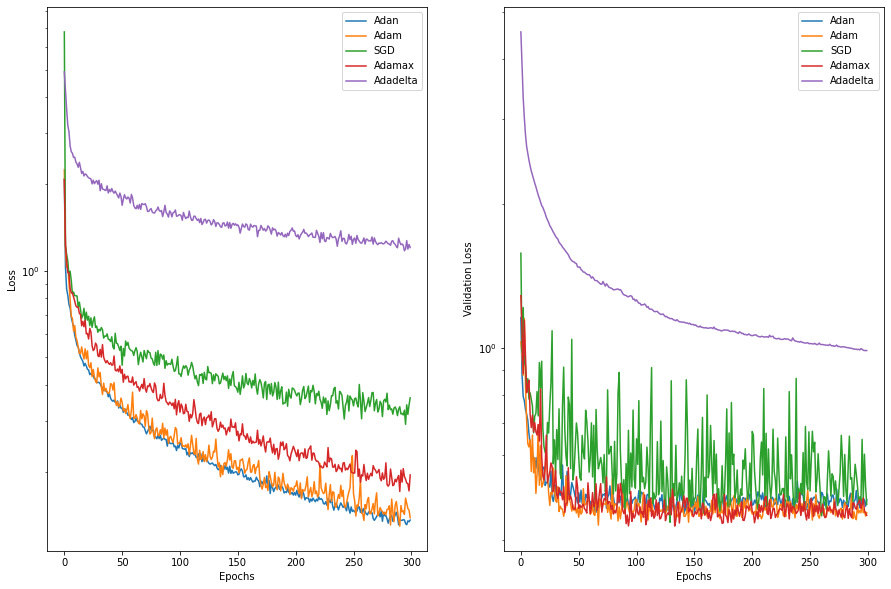

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,10))
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[0].plot(hist_run.history["loss"], label=opt.get_config()["name"])
    axs[0].set_ylabel("Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_yscale("log")
    axs[0].legend()
for hist_run, opt in zip(hist_opt, opt_selection):
    axs[1].plot(hist_run.history["val_loss"], label=opt.get_config()["name"])
    axs[1].set_ylabel("Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_yscale("log")
    axs[1].legend()